In [25]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.io import imread
from skimage.feature import peak_local_max
from scipy import ndimage as ndi
from skimage.segmentation import watershed
from skimage.morphology import label, remove_small_objects
from skimage.measure import label, regionprops
from math import sqrt, pi

In [36]:
from glob import glob
img_path = glob('{}*{}'.format('Dataset/*/tissue images/', 'png'))
binary_mask_path = glob('{}*{}'.format('Dataset/*/mask binary/', 'png'))
distance_mask_path = glob('{}*{}'.format('Dataset/*/distance maps/', 'png'))
label_mask_path = glob('{}*{}'.format('Dataset/*/label masks modify/', 'tif'))

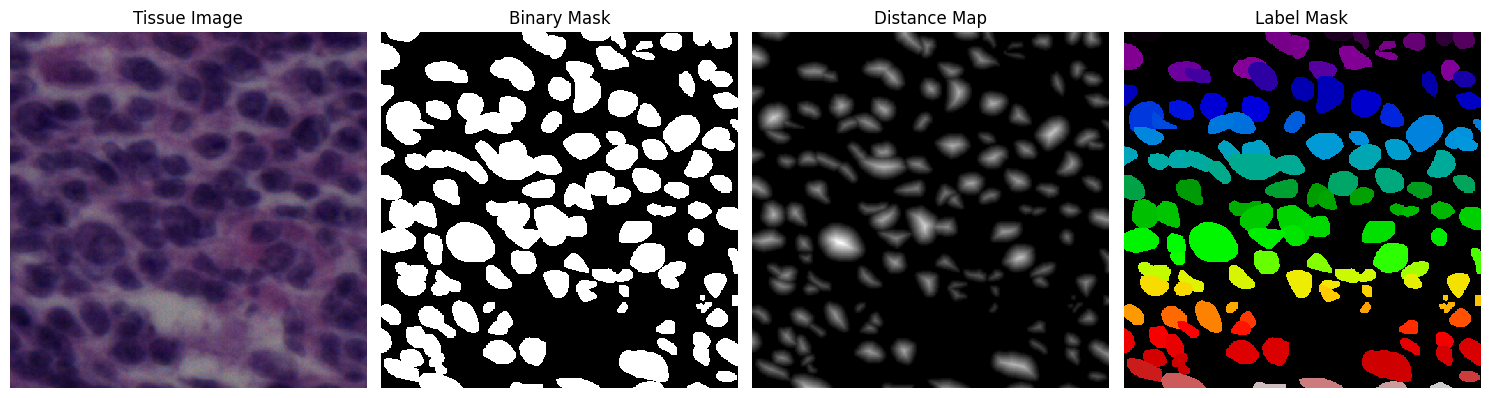

In [40]:
x=25
img = imread(img_path[x])
binary_mask = imread(binary_mask_path[x])
distance_mask = imread(distance_mask_path[x])
label_mask = imread(label_mask_path[x])
plt.figure(figsize=(15, 5))
titles = ['Tissue Image', 'Binary Mask', 'Distance Map', 'Label Mask']
images = [img, binary_mask, distance_mask,label_mask]
cmaps = [None, 'gray', 'gray', 'nipy_spectral']

for i, (im, title, cmap) in enumerate(zip(images, titles, cmaps), start=1):
    ax = plt.subplot(1, 4, i)
    if cmap:
        ax.imshow(im, cmap=cmap, interpolation='none')
    else:
        ax.imshow(im, interpolation='none')
    ax.set_title(title)
    ax.axis('off')

plt.tight_layout()
plt.show()



In [10]:


# --- CONFIGURATION: UPDATE THESE VALUES ---
# 1. FILE PATHS: Point these to your actual U-Net output images
#    (e.g., a single slice of pred_seg and pred_dis arrays saved as 8-bit images).
SEMANTIC_PROB_PATH = binary_mask_path[x]  # Example: 'pred_seg_prob.png'
DISTANCE_PROB_PATH = distance_mask_path[x]  # Example: 'pred_dis_prob.png'

# 2. PARAMETERS
THRESHOLD = 0.5  # Corresponds to opts['treshold']
MIN_SIZE = 50    # Corresponds to min_size in remove_small_objects
FOOTPRINT_SIZE = 15 # Fixed size (consider using dynamic logic for better results)

In [30]:


# --- UTILITY FUNCTIONS (Must be defined for your pipeline to work) ---

# Note: You need to implement these functions locally or copy them from your full script.
# The placeholder logic below will be sufficient for a basic test.

def calculate_average_nucleus_diameter(binary_mask_array,min_area_threshold=50):
    """Placeholder: Calculates average diameter based on the semantic mask."""
    # If you skip this, use a fixed sigma below.
    # return 12 
    labeled_mask = label(binary_mask_array > 0)

    # 2. Calculate properties (Area) for each labeled region
    props = regionprops(labeled_mask)
    all_areas = []

    # 3. Collect areas
    for prop in props:
        if prop.area >= min_area_threshold:
            all_areas.append(prop.area)

    if not all_areas:
        # Fallback to a common size if no objects are detected
        return 20.0 

    # 4. Calculate average area
    average_area = np.mean(all_areas)
    
    # 5. Convert average area to equivalent diameter (D)
    average_diameter_pixels = 2 * sqrt(average_area / pi)
    
    return average_diameter_pixels

def apply_gaussian_smoothing(pred_dis_slice, avg_nuclei):
    """Placeholder: Applies smoothing to the distance map."""
    sigma = avg_nuclei / 2.0
    return ndi.gaussian_filter(pred_dis_slice, sigma=sigma)

def remap_label(labeled_image):
    """Placeholder: Ensures labels are continuous (0, 1, 2, 3...)."""
    # This is often done using measure.label(..., connectivity=None) in skimage, 
    # but a custom function is common.
    if labeled_image.max() == 0:
        return labeled_image
    # Simple remapping: Find unique labels > 0 and assign new IDs
    unique_labels = np.unique(labeled_image)
    if unique_labels[0] == 0:
        unique_labels = unique_labels[1:]
    
    # Create a mapping from old IDs to new IDs (1, 2, 3, ...)
    mapping = np.zeros(labeled_image.max() + 1, dtype=labeled_image.dtype)
    mapping[unique_labels] = np.arange(1, len(unique_labels) + 1)
    return mapping[labeled_image]


# --------------------------------------------------------------------
# --- CORE POST-PROCESSING FUNCTION (with the CRITICAL FIX) ---
# --------------------------------------------------------------------

def post_process_nuclei(pred_dis_slice, pred_seg_slice, threshold, min_size):
    """
    Applies both Pure U-Net labeling and U-Net + Watershed for instance segmentation.
    
    Returns: output_watershed (labeled array), output_raw (labeled array), smoothed_dis
    """
    
    # --- 1. U-Net + Watershed Pipeline ---
    avg_nuclei = calculate_average_nucleus_diameter(pred_seg_slice)
    smoothed_dis = apply_gaussian_smoothing(pred_dis_slice, avg_nuclei)
    footprint_size = max(3, int(avg_nuclei * 0.8) // 2 * 2 + 1)
    
    # 1a. Find local maxima (seeds/markers) - Uses the coordinates output method
    peak_coords = peak_local_max(
        np.squeeze(smoothed_dis), 
        exclude_border=False, 
        footprint=np.ones((footprint_size, footprint_size))
    )
    
    # 1b. Convert coordinates to binary mask (local_maxi)
    image_shape = np.squeeze(smoothed_dis).shape
    local_maxi = np.zeros(image_shape, dtype=bool)
    if peak_coords.size > 0:
        local_maxi[peak_coords[:, 0], peak_coords[:, 1]] = True
        
    # 1c. Label markers and define watershed mask
    marker = ndi.label(local_maxi)[0]
    pred_val_t = (pred_seg_slice > threshold).astype(np.uint8)
    
    # 1d. Run Watershed
    # Note: Using negative smoothed_dis for watershed to treat peaks as basins
    output_watershed = watershed(-np.squeeze(smoothed_dis), marker, mask=pred_val_t)
    
    # Clean up and remap
    output_watershed[pred_val_t==0] = 0
    output_watershed = remove_small_objects(output_watershed, min_size=min_size, connectivity=2)
    output_watershed = remap_label(output_watershed)
    
    
    # --- 2. Pure U-Net Pipeline (FIXED: Binarization added) ---
    
    # CRITICAL FIX: Binarize the raw probability map first before labeling
    output_raw_binarized = (np.squeeze(pred_seg_slice) > threshold).astype(np.uint8)
    
    # Apply connected component labeling to the binarized mask
    output_raw = label(output_raw_binarized) 
    
    # Clean up and remap
    output_raw = remove_small_objects(output_raw, min_size=min_size, connectivity=2)
    output_raw = remap_label(output_raw)
    
    return output_watershed, output_raw, smoothed_dis


# --------------------------------------------------------------------
# --- EXECUTION AND VISUALIZATION ---
# --------------------------------------------------------------------

# Load the actual prediction files


In [31]:
try:
    # Load as float and normalize if necessary (PNG usually loads as 0-255)
    pred_seg_prob = imread(SEMANTIC_PROB_PATH).astype(float) / 255.0
    pred_dis_prob = imread(DISTANCE_PROB_PATH).astype(float) / 255.0
except FileNotFoundError:
    print("FATAL ERROR: One or both prediction files not found.")
    print(f"Please check paths: {SEMANTIC_PROB_PATH} and {DISTANCE_PROB_PATH}")
    exit()





In [32]:
# Run the fixed pipeline
output_watershed, output_raw, smoothed_dis = \
    post_process_nuclei(pred_dis_prob, pred_seg_prob, THRESHOLD, MIN_SIZE)

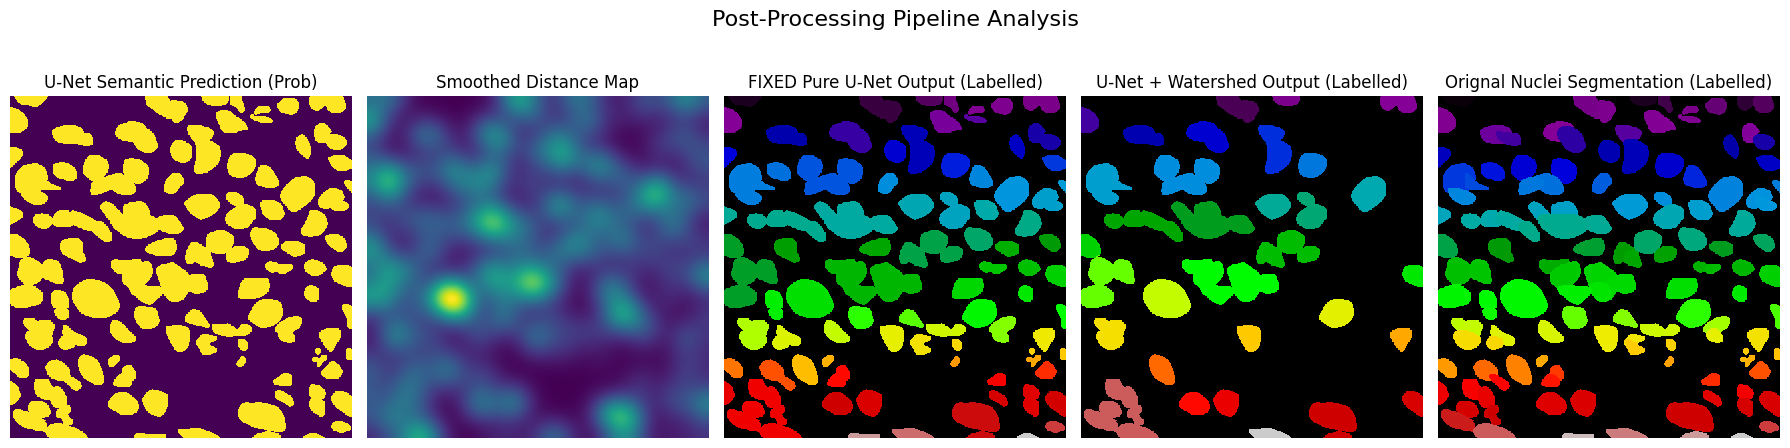


--- Verification ---
Pure U-Net Object Count: 85 (Should now be > 0)
U-Net + Watershed Object Count: 32


In [42]:

# Visualization
fig, axes = plt.subplots(1, 5, figsize=(18, 5))
titles = [
    "U-Net Semantic Prediction (Prob)", 
    "Smoothed Distance Map",
    "FIXED Pure U-Net Output (Labelled)", 
    "U-Net + Watershed Output (Labelled)",
    "Orignal Nuclei Segmentation (Labelled)"
]
images = [
    pred_seg_prob, 
    smoothed_dis, 
    output_raw, 
    output_watershed,
    label_mask
    
]

for ax, img, title in zip(axes, images, titles):
    # Use 'nipy_spectral' for labeled output to distinguish instances
    cmap = 'nipy_spectral' if title.endswith('(Labelled)') else 'viridis'
    ax.imshow(img, cmap=cmap, interpolation='none')
    ax.set_title(title, fontsize=12)
    ax.axis('off')

plt.suptitle("Post-Processing Pipeline Analysis", fontsize=16)
plt.tight_layout()
plt.show()

# Print out object counts for verification
print("\n--- Verification ---")
print(f"Pure U-Net Object Count: {output_raw.max()} (Should now be > 0)")
print(f"U-Net + Watershed Object Count: {output_watershed.max()}")